<a href="https://colab.research.google.com/github/Van314159/RL/blob/main/TD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twin Delayed Deep Deterministic Policy Gradient (TD3)

📅 *2025-06-30*  
📖 *Reference: Chapter 12,* **Grokking Deep Reinforcement Learning** *(2020)*

This notebook implements and trains a TD3 agent to solve the Pendulum-v1 env and Hopper env from Gymnasium. TD3 is a direct improvement of DDPG (deep deterministic policy gradient).

Note to use the Hopper env, we **must** work in the GPU.


In [ ]:
import numpy as np
import gymnasium as gym
from gym import spaces
import random
import matplotlib.pyplot as plt
from statistics import mean # For mean reward logging
import pickle # For saving/loading the best episode trajectory
from collections import deque
import collections
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.distributions import Categorical
import os
from itertools import count

from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/My Drive/TensorBoard"

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
SEEDS = (12, 34, 56, 78, 90)

Using device: cuda


## Visualization Function

In [ ]:
import imageio
from IPython.display import Video, display
def visualize_and_generate_video(trained_net, env, evaluation_strategy, video_filename='agent_interaction.mp4'):

    print("--- Starting visualization ---")
    trained_net.eval()

    frames = []
    obs, _ = env.reset()
    done = False
    episode_reward = 0

    while not done:
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        action = evaluation_strategy.select_action(trained_net, obs_tensor,return_numpy=True)

        # Apply the action to the environment
        obs, reward, terminated, truncated, info = env.step(action.flatten())

        # An episode is 'done' if it's terminated (e.g., pole fell) or truncated (e.g., time limit)
        done = terminated or truncated

        episode_reward += reward

        # Render the environment to an RGB array and add it to our list of frames
        frame = env.render()
        frames.append(frame)
    trained_net.train()
    env.close()

    print(f"--- Visualization complete. Total reward: {episode_reward} ---")

    # Use imageio to save the collected frames as a video (MP4 format)
    print(f"--- Saving video to {video_filename} ---")
    with imageio.get_writer(video_filename, fps=30) as video:
        for frame in frames:
            video.append_data(frame)
    print("--- Video saved successfully ---")

    # Display the generated video directly in the Colab output
    display(Video(video_filename, embed=True))

## Twin Q-value network

In [ ]:
# DDPG's twin Q-function network.
class QTwinNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=(32,32),
                 activation=F.relu):
        super().__init__()
        self.activation = activation

        # Construct sequence deep network
        self.input_layer_a = nn.Linear(input_dim+output_dim, hidden_dim[0])
        self.input_layer_b = nn.Linear(input_dim+output_dim, hidden_dim[0])
        self.hidden_layers_a = nn.ModuleList()
        self.hidden_layers_b = nn.ModuleList()
        for i in range(len(hidden_dim)-1):
            hidden_layer_a = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            hidden_layer_b = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            self.hidden_layers_a.append(hidden_layer_a)
            self.hidden_layers_b.append(hidden_layer_b)

        self.output_layer_a = nn.Linear(hidden_dim[-1], 1)
        self.output_layer_b = nn.Linear(hidden_dim[-1], 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        xa = self.activation(self.input_layer_a(x))
        xb = self.activation(self.input_layer_b(x))

        for hidden_layer_a, hidden_layer_b in zip(self.hidden_layers_a,self.hidden_layers_b):
            xa = self.activation(hidden_layer_a(xa))
            xb = self.activation(hidden_layer_b(xb))

        return self.output_layer_a(xa), self.output_layer_b(xb)

    def Qa(self, state, action):
        x = torch.cat([state, action], dim=1)
        xa = self.activation(self.input_layer_a(x))

        for hidden_layer_a in self.hidden_layers_a:
            xa = self.activation(hidden_layer_a(xa))
        return  self.output_layer_a(xa)



In [ ]:
# DDPG's deterministic policy network
class PolicyNet(nn.Module):
    def __init__(self, input_dim, action_bounds,
                 hidden_dims=(32,32), activation=F.relu,
                 out_activation=torch.tanh):
        super().__init__()
        self.activation = activation
        self.out_activation = out_activation
        env_min, env_max = action_bounds
        self.register_buffer("env_min", torch.tensor(env_min, dtype=torch.float32))
        self.register_buffer("env_max", torch.tensor(env_max, dtype=torch.float32))

        # Construct net
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], len(env_max))

    def forward(self, state):
        x = self.activation(self.input_layer(state))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.out_activation(self.output_layer(x))
        return self.rescale_fn(x)

    def rescale_fn(self, x):
        return self.env_min + 0.5 * (x + 1.0) * (self.env_max - self.env_min)


## NormalNoiseStrategy, ReplyBuffler, and Greedy Strategy

In [ ]:
# Exploration in DPPG
class NormalNoiseStrategy():
    def __init__(self, bounds, exploration_noise_ratio=0.1):
        low, high = bounds
        self.low = torch.tensor(low, dtype=torch.float32)
        self.high = torch.tensor(high, dtype=torch.float32)
        self.exploration_noise_ratio = exploration_noise_ratio
        self.ratio_noise_injected = 0.0

    def select_action(self, model, state, max_exploration=False):
        # model: policy network
        # Explotition: low noise variance of policy
        # exploration: large noise variance of policy
        model.eval()
        with torch.no_grad():
            greedy_action = model(state).cpu().squeeze().numpy()

        if max_exploration:
            noise_scale = self.high.numpy()
        else:
            noise_scale = self.exploration_noise_ratio * (self.high - self.low).numpy()

        noise = np.random.normal(0, noise_scale)
        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low.numpy(), self.high.numpy())

        # Estimate how much noise was injected (average relative change)
        self.ratio_noise_injected = np.mean(
            np.abs((greedy_action - action) / (self.high.numpy() - self.low.numpy()))
        )
        return action

In [ ]:
# Exploration in DPPG
class NormalNoiseDecayStrategy():
    def __init__(self, bounds, initial_noise_scale=0.5,
                 final_noise_scale=0.1, decay_steps=10000, device='cpu'):
        low, high = bounds
        self.low = torch.tensor(low, dtype=torch.float32,device=device)
        self.high = torch.tensor(high, dtype=torch.float32,device=device)
        self.action_range = self.high - self.low
        self.device = device

        self.initial_noise_scale = initial_noise_scale
        self.final_noise_scale = final_noise_scale
        self.decay_steps = decay_steps
        self.ratio_noise_injected = 0.0
        self.current_step = 0

    def select_action(self, model, state, current_timestep):
        # model: policy network
        # Explotition: low noise variance of policy
        # exploration: large noise variance of policy
        model.eval()
        with torch.no_grad():
            greedy_action = model(state).squeeze().to(self.device)

        if current_timestep >= self.decay_steps:
            current_noise_scale = self.final_noise_scale
        else:
            decay_progress = current_timestep / self.decay_steps
            current_noise_scale = self.initial_noise_scale + decay_progress * (self.final_noise_scale - self.initial_noise_scale)

        noise_std = current_noise_scale * self.action_range
        noise = torch.normal(0.0, noise_std).to(self.device)
        noisy_action = torch.clamp(greedy_action + noise, self.low, self.high)

        # Estimate how much noise was injected (average relative change)
        self.ratio_noise_injected = torch.mean(
            torch.abs((greedy_action - noisy_action) / self.action_range)
        ).item()

        return noisy_action.cpu().numpy()

In [ ]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=100_000, batch_size=64, device="cpu"):
        self.max_size = max_size
        self.batch_size = batch_size
        self.device = device

        # Preallocate fixed-size numpy arrays
        self.state_buf = np.zeros((self.max_size, state_dim), dtype=np.float32)
        self.action_buf = np.zeros((self.max_size, action_dim), dtype=np.float32)
        self.reward_buf = np.zeros((self.max_size, 1), dtype=np.float32)
        self.next_state_buf = np.zeros((self.max_size, state_dim), dtype=np.float32)
        self.done_buf = np.zeros((self.max_size, 1), dtype=np.float32)

        # Pointers.
        self._ptr = 0
        self.size = 0

    def store(self, state, action, reward, next_state, done):
        # Add a new step (s,a,r,s',d).
        self.state_buf[self._ptr] = state
        self.action_buf[self._ptr] = action
        self.reward_buf[self._ptr] = reward
        self.next_state_buf[self._ptr] = next_state
        self.done_buf[self._ptr] = done

        self._ptr = (self._ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        idxs = np.random.choice(self.size, batch_size, replace=False)

        # Return as PyTorch tensors on correct device
        return (
            torch.tensor(self.state_buf[idxs], dtype=torch.float32, device=self.device),
            torch.tensor(self.action_buf[idxs], dtype=torch.float32, device=self.device),
            torch.tensor(self.reward_buf[idxs], dtype=torch.float32, device=self.device),
            torch.tensor(self.next_state_buf[idxs], dtype=torch.float32, device=self.device),
            torch.tensor(self.done_buf[idxs], dtype=torch.float32, device=self.device),
        )

    def __len__(self):
        return self.size

In [ ]:
class GreedyStrategy():
    def __init__(self, action_bounds, device="cpu"):
        self.low = torch.tensor(action_bounds[0], dtype=torch.float32, device=device)
        self.high = torch.tensor(action_bounds[1], dtype=torch.float32, device=device)
        self.device = device
        self.ratio_noise_injected = 0

    def select_action(self, model, state, return_numpy=True):
        """
        Args:
            model: policy network
            state: torch.Tensor (1D or batched) on the correct device
            return_numpy: whether to return NumPy array or keep it as torch.Tensor
        """
        with torch.no_grad():
            action = model(state.to(self.device))
            action = torch.clamp(action, self.low, self.high)

        if return_numpy:
            return action.cpu().numpy()
        return action

## TD3 Agent

In [ ]:
# TD3 agent
import time
from datetime import datetime
import pytz
import copy

class TD3Agent():
    def __init__(self, env, policy_net, policy_max_grad_norm, policy_lr,
                 twin_value_net, value_max_grad_norm, value_lr, tau, gamma,
                 policy_noise_ratio, policy_noise_clip,
                 policy_update_freq,
                 device="cpu", save_every_episodes=100):

        self.policy_noise_ratio = policy_noise_ratio
        self.policy_noise_clip = policy_noise_clip
        self.policy_update_freq = policy_update_freq


        self.tau = tau
        self.gamma = gamma
        self.device = device
        self.train_step = 0
        self.total_env_step = 0

        self.env = env
        self.env_name = getattr(env, "spec", None).id if getattr(env, "spec", None) else "UnknownEnv"
        self.action_low = torch.tensor(env.action_space.low, dtype=torch.float32, device=device)
        self.action_high = torch.tensor(env.action_space.high, dtype=torch.float32, device=device)

        # Set Online net
        self.online_policy_net = policy_net.to(device)
        self.online_value_net = twin_value_net.to(device)

        # Set Target network.
        self.target_policy_net = copy.deepcopy(self.online_policy_net)
        self.target_value_net = copy.deepcopy(self.online_value_net)
        self.target_policy_net.load_state_dict(self.online_policy_net.state_dict())
        self.target_value_net.load_state_dict(self.online_value_net.state_dict())

        # Optimizers
        self.policy_optimizer = torch.optim.Adam(self.online_policy_net.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.online_value_net.parameters(), lr=value_lr)
        self.policy_max_grad_norm = policy_max_grad_norm
        self.value_max_grad_norm = value_max_grad_norm

        # TensorBoard Setup
        tokyo = pytz.timezone('Asia/Tokyo')
        timestamp = datetime.now(tokyo).strftime('%Y%m%d-%H%M')
        log_dir = os.path.join(DIR, f"{timestamp}_{self.env_name}_TD3")
        os.makedirs(log_dir, exist_ok=True)
        self.writer = SummaryWriter(log_dir)
        print(f"TensorBoard logs being written to: {log_dir}")

    def train(self, replay_buffer, batch_size,
              max_minutes, max_episodes, goal_mean_100_reward,
              exploration_strategy, evaluation_strategy):

        self.replay_buffer = replay_buffer
        self.exploration_strategy = exploration_strategy
        self.evaluation_strategy = evaluation_strategy
        self.total_env_step = 0
        scores = []

        start_time = time.time()

        # Collect experiences
        for episode in range(1, max_episodes + 1):
            episode_step = 0
            obs, _ = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                episode_step += 1
                obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
                action = self.exploration_strategy.select_action(self.online_policy_net, obs_tensor, self.total_env_step)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                replay_buffer.store(obs, action, reward, next_obs, float(done))
                obs = next_obs
                total_reward += reward
                self.total_env_step += 1

                if len(self.replay_buffer) >= batch_size:
                    self.update_online_model(self.replay_buffer.sample(batch_size))


            scores.append(total_reward)
            mean_100 = np.mean(scores[-100:])

            if episode % 10 == 0:
                print(f"Episode {episode} | Reward: {total_reward:.1f} | Mean(100): {mean_100:.1f}")

            if mean_100 >= goal_mean_100_reward:
                print("🎯 Goal achieved!")
                break

            elapsed = time.time() - start_time
            if elapsed > max_minutes * 60:
                print("⏰ Time budget exceeded.")
                break

            self.writer.add_scalar("Reward/Episode", total_reward, episode)
            self.writer.add_scalar("Reward/Mean100", mean_100, episode)

            if episode % save_every_episodes == 0:
                save_dir = self.writer.log_dir
                save_path = os.path.join(save_dir, f"Policy_episode_{episode}.pth")
                print(f"\n--- Saving model checkpoint to {save_path} ---")
                torch.save(self.online_policy_net.state_dict(), save_path)
        final_score, std = self.evaluate(n_episode=10)
        # --- Also save the final model at the very end of training ---
        final_save_path = os.path.join(self.writer.log_dir, "actor_final.pth")
        print(f"\n--- Saving final model to {final_save_path} ---")
        torch.save(self.online_policy_net.state_dict(), final_save_path)

        self.env.close()
        self.writer.close()
        print(f"\n✅ Training complete. Final eval: {final_score:.2f} ± {std:.2f}")
        return final_score

    def evaluate(self, n_episode=1):
        rs = []
        self.online_policy_net.eval()
        for _ in range(n_episode):
            obs, _ = self.env.reset()
            is_done = False
            episode_rs = 0
            while not is_done:
                obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                action = self.evaluation_strategy.select_action(self.online_policy_net, obs_tensor)
                next_obs, reward, termin, trunc, _ = self.env.step(action.flatten())
                is_done = termin or trunc
                episode_rs += reward
                obs = next_obs

            rs.append(episode_rs)

        self.online_policy_net.train()
        return np.mean(rs), np.std(rs)


    def update_online_model(self, batch):
        self.train_step += 1
        # Compare to a public target network which is updated regularly.
        states, actions, rewards, next_states, dones = batch
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        batch_size = len(dones)

        # Add noise to the action.
        with torch.no_grad():
            noise = (torch.randn_like(actions) * self.policy_noise_ratio).clamp(-self.policy_noise_clip, self.policy_noise_clip)
            action_preds_noise = (self.target_policy_net(next_states) + noise).clamp(self.action_low, self.action_high)
            next_values_a, next_values_b = self.target_value_net(next_states, action_preds_noise)
            next_values = torch.min(next_values_a, next_values_b)
            target_values = rewards + (1 - dones) * self.gamma * next_values



        # calculate the joint value loss and update private network.
        value_a, value_b = self.online_value_net(states, actions)
        value_loss = F.mse_loss(target_values, value_a) + F.mse_loss(target_values, value_b)

        self.value_optimizer.zero_grad()
        value_loss.backward()
        nn.utils.clip_grad_norm_(self.online_value_net.parameters(), self.value_max_grad_norm)
        self.value_optimizer.step()
        self.writer.add_scalar("Loss/Value", value_loss.item(), self.total_env_step)
        self.writer.add_scalar("Q_value/Target", target_values.mean().item(), self.total_env_step)
        self.writer.add_scalar("Q_value/OnlineA", value_a.mean().item(), self.total_env_step)
        self.writer.add_scalar("Q_value/OnlineB", value_b.mean().item(), self.total_env_step)

        # calculate policy loss
        if self.train_step % self.policy_update_freq == 0:
            policy_loss = - self.online_value_net.Qa(states, self.online_policy_net(states)).mean()
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            nn.utils.clip_grad_norm_(self.online_policy_net.parameters(), self.policy_max_grad_norm)
            self.policy_optimizer.step()
            self.writer.add_scalar("Loss/Policy", policy_loss.item(), self.train_step)
            self.update_target_model()



    def update_target_model(self):
        for target_param, param in zip(self.target_value_net.parameters(), self.online_value_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.target_policy_net.parameters(), self.online_policy_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
b


In [ ]:
env = gym.make("Pendulum-v1")

In [ ]:
GAMMA = 0.99
MAX_MINUTES = 20
MAX_EPISODES = 500
GOAL_MEAN_100_REWARD = -150
POLICY_LR = 0.0003
VALUE_LR = 0.0003
TAU = 0.005
POLICY_UPDATE_FREQ = 4
HIDDEN_DIM = (256, 256)
LR = 3e-4
NOISE_CLIP = 0.5
POLICY_NOISE_RATIO = 0.2

In [ ]:
state_dim = env.observation_space.shape[0]        # (3,)
action_dim = env.action_space.shape[0]         # 1
action_low = env.action_space.low              # array([-2.])
action_high = env.action_space.high            # array([2.])
action_bounds = (action_low, action_high)

In [ ]:
policynet = PolicyNet(input_dim=state_dim, action_bounds=action_bounds, hidden_dims=(128,128))
value_net = QTwinNetwork(input_dim=state_dim, output_dim=action_dim, hidden_dim=HIDDEN_DIM)

In [ ]:
obs, _ = env.reset()
obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
action = policynet(obs_tensor)
value_net(obs_tensor, action)

(tensor([[-0.0920]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0138]], grad_fn=<AddmmBackward0>))

In [ ]:
exploration_strategy = NormalNoiseDecayStrategy(action_bounds)
evaluation_strategy=GreedyStrategy(action_bounds, device=device)
exploration_strategy.select_action(policynet, obs_tensor, 1)

array([-2.], dtype=float32)

In [ ]:
td3_agent = TD3Agent(env,policy_net=policynet, policy_max_grad_norm=2.0,policy_lr=LR,
                        twin_value_net=value_net, value_max_grad_norm=2.0, value_lr=LR,
                        policy_update_freq=POLICY_UPDATE_FREQ,
                        gamma=GAMMA, policy_noise_ratio=POLICY_NOISE_RATIO, policy_noise_clip=NOISE_CLIP,
                       tau=TAU, device=device)

TensorBoard logs being written to: /content/drive/My Drive/TensorBoard/20250627-1715_Pendulum-v1_TD3


In [ ]:
replay_buffer = ReplayBuffer(max_size=100000, batch_size=256,
                             state_dim=state_dim, action_dim=action_dim, device=device)

In [ ]:
td3_agent.train(replay_buffer=replay_buffer, batch_size=256,
                 max_minutes=20, max_episodes=500,
                 goal_mean_100_reward=GOAL_MEAN_100_REWARD,
                 exploration_strategy=exploration_strategy,
                 evaluation_strategy=evaluation_strategy)

In [ ]:
test_env = gym.make("Pendulum-v1", render_mode="rgb_array")
test_env.reset()
visualize_and_generate_video(td3_agent.target_policy_net, test_env, evaluation_strategy=GreedyStrategy(action_bounds, device=device),video_filename='agent_interaction.mp4')

--- Starting visualization ---


--- Visualization complete. Total reward: -234.7337850502321 ---
--- Saving video to agent_interaction.mp4 ---
--- Video saved successfully ---


In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/My Drive/TensorBoard/"

# Train Hopper Env

The below import cell copies from the notebook [Model Editing in MuJoCo Env](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/mjspec.ipynb#scrollTo=sJFuNetilv4m).

In [ ]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was successful.
try:
  print('Checking that the installation succeeded:')
  import mujoco as mj
  mj.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import numpy as np
import random
from scipy.signal import convolve2d

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Printing.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
import pygments
from google.colab import output

from IPython.display import clear_output, HTML, display
clear_output()


is_dark = output.eval_js('document.documentElement.matches("[theme=dark]")')
print_style = 'monokai' if is_dark else 'lovelace'

def print_xml(xml_string):
  formatter = pygments.formatters.HtmlFormatter(style=print_style)
  lexer = pygments.lexers.XmlLexer()
  highlighted = pygments.highlight(xml_string, lexer, formatter)
  display(HTML(f"<style>{formatter.get_style_defs()}</style>{highlighted}"))

def render(model, data=None, height=300, camera=-1):
  if data is None:
    data = mj.MjData(model)
  with mj.Renderer(model, 480, 640) as renderer:
    mj.mj_forward(model, data)
    renderer.update_scene(data, camera)
    media.show_image(renderer.render(), height=height)

In [ ]:
import gymnasium as gym
env = gym.make("Hopper-v5", render_mode="rgb_array")

In [ ]:
obs, _ = env.reset()

array([ 1.255,  0.   ,  0.003,  0.   , -0.003, -0.   , -0.004,  0.003, -0.001,  0.005,  0.005])

array([[[ 67,  84, 101],
        [ 67,  84, 101],
        [ 67,  84, 101],
        ...,
        [ 67,  84, 101],
        [ 67,  84, 101],
        [ 67,  84, 101]],

       [[ 67,  84, 101],
        [ 67,  84, 101],
        [ 67,  84, 101],
        ...,
        [ 67,  84, 101],
        [ 67,  84, 101],
        [ 67,  84, 101]],

       [[ 67,  84, 101],
        [ 67,  84, 101],
        [ 67,  84, 101],
        ...,
        [ 67,  84, 101],
        [ 67,  84, 101],
        [ 67,  84, 101]],

       ...,

       [[179, 202, 179],
        [178, 200, 178],
        [126, 142, 126],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[178, 200, 178],
        [127, 143, 127],
        [ 59,  66,  59],
        ...,
        [ 43,  48,  43],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[127, 143, 127],
        [ 59,  66,  59],
        [  7,   7,   7],
        ...,
        [110, 124, 110],
        [ 42,  47,  42],
        [  0,   0,   0]]], dtype=uint8)
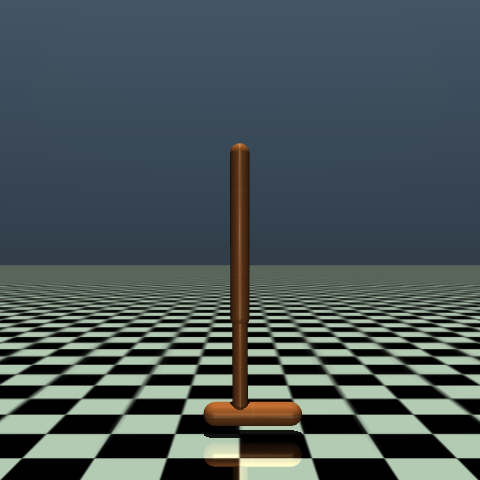

In [ ]:
env.render()

In [ ]:
import glob
from IPython.display import HTML
from base64 import b64encode
from IPython.display import Video, display as iPythonDisplay

In [ ]:
env = gym.make("Hopper-v5", render_mode="rgb_array")
env.reset()

(array([ 1.25 , -0.003, -0.004, -0.001,  0.002,  0.001, -0.004,  0.003,  0.001, -0.001,  0.001]),
 {'x_position': np.float64(-0.00018224987126816677),
  'z_distance_from_origin': np.float64(-3.471200155158449e-05)})

In [ ]:
GAMMA = 0.99
MAX_MINUTES = 20
MAX_EPISODES = 500
GOAL_MEAN_100_REWARD = 1500
POLICY_LR = 0.0003
VALUE_LR = 0.0003
TAU = 0.005
POLICY_UPDATE_FREQ = 4
HIDDEN_DIM = (256, 256)
LR = 3e-4
NOISE_CLIP = 0.5
POLICY_NOISE_RATIO = 0.2

In [ ]:
state_dim = env.observation_space.shape[0]        # (3,)
action_dim = env.action_space.shape[0]         # 1
action_low = env.action_space.low              # array([-2.])
action_high = env.action_space.high            # array([2.])
action_bounds = (action_low, action_high)

In [ ]:
policynet = PolicyNet(input_dim=state_dim, action_bounds=action_bounds, hidden_dims=(128,128))
value_net = QTwinNetwork(input_dim=state_dim, output_dim=action_dim, hidden_dim=HIDDEN_DIM)

In [ ]:
obs, _ = env.reset()
obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
action = policynet(obs_tensor)
value_net(obs_tensor, action)

(tensor([[-0.0695]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0039]], grad_fn=<AddmmBackward0>))

In [ ]:
exploration_strategy = NormalNoiseDecayStrategy(action_bounds)
evaluation_strategy=GreedyStrategy(action_bounds, device=device)
exploration_strategy.select_action(policynet, obs_tensor, 1)

array([ 1.   ,  1.   , -0.238], dtype=float32)

In [ ]:
td3_agent = TD3Agent(env,policy_net=policynet, policy_max_grad_norm=2.0,policy_lr=LR,
                        twin_value_net=value_net, value_max_grad_norm=2.0, value_lr=LR,
                        policy_update_freq=POLICY_UPDATE_FREQ,
                        gamma=GAMMA, policy_noise_ratio=POLICY_NOISE_RATIO, policy_noise_clip=NOISE_CLIP,
                       tau=TAU, device=device)

TensorBoard logs being written to: /content/drive/My Drive/TensorBoard/20250627-2251_Hopper-v5_TD3


In [ ]:
replay_buffer = ReplayBuffer(max_size=100000, batch_size=256,
                             state_dim=state_dim, action_dim=action_dim, device=device)

In [ ]:
td3_agent.train(replay_buffer=replay_buffer, batch_size=256,
                 max_minutes=300, max_episodes=10000,
                 goal_mean_100_reward=GOAL_MEAN_100_REWARD,
                 exploration_strategy=exploration_strategy,
                 evaluation_strategy=evaluation_strategy)

Episode 10 | Reward: 197.0 | Mean(100): 109.4
Episode 20 | Reward: 186.6 | Mean(100): 125.8
Episode 30 | Reward: 176.8 | Mean(100): 139.0
Episode 40 | Reward: 183.6 | Mean(100): 149.0
Episode 50 | Reward: 216.0 | Mean(100): 156.4
Episode 60 | Reward: 191.6 | Mean(100): 161.0
Episode 70 | Reward: 225.9 | Mean(100): 163.9
Episode 80 | Reward: 203.4 | Mean(100): 171.0
Episode 90 | Reward: 221.9 | Mean(100): 175.8
Episode 100 | Reward: 202.1 | Mean(100): 178.6
Episode 110 | Reward: 231.6 | Mean(100): 188.5
Episode 120 | Reward: 32.5 | Mean(100): 196.4
Episode 130 | Reward: 278.6 | Mean(100): 195.6
Episode 140 | Reward: 239.0 | Mean(100): 205.0
Episode 150 | Reward: 234.9 | Mean(100): 210.6
Episode 160 | Reward: 238.0 | Mean(100): 215.6
Episode 170 | Reward: 122.7 | Mean(100): 220.0
Episode 180 | Reward: 272.7 | Mean(100): 218.5
Episode 190 | Reward: 237.2 | Mean(100): 221.1
Episode 200 | Reward: 281.2 | Mean(100): 226.9
Episode 210 | Reward: 323.1 | Mean(100): 233.0
Episode 220 | Reward: 2

np.float64(3148.770221597885)

In [ ]:
test_env = gym.make("Pendulum-v1", render_mode="rgb_array")
test_env.reset()
visualize_and_generate_video(td3_agent.target_policy_net, test_env, evaluation_strategy=GreedyStrategy(action_bounds, device=device),video_filename='agent_interaction.mp4')


In [ ]:
# Assuming 'ddpg_agent' is your trained agent instance from the old definition
print("--- Saving the trained policy network ---")

# Define a path for your saved model
save_path = "old_td3_policy_net.pth"

# Save the state dictionary of the online policy network
# This is the network that contains the final, learned policy.
torch.save(td3_agent.online_policy_net.state_dict(), save_path)

print(f"Model weights saved successfully to {save_path}")

--- Saving the trained policy network ---
Model weights saved successfully to old_td3_policy_net.pth


In [ ]:
new_policy_net = PolicyNet(input_dim=state_dim, action_bounds=action_bounds, hidden_dims=(128,128))
model_path = os.path.join(DIR, "20250627-2251_Hopper-v5_TD3/td3_policy_net_finial_Hopper.pth")
new_policy_net.load_state_dict(torch.load(model_path))
new_policy_net.to(device)
new_policy_net.eval()

PolicyNet(
  (input_layer): Linear(in_features=11, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
test_env = gym.make("Hopper-v5", render_mode="rgb_array")
test_env.reset()
visualize_and_generate_video(new_policy_net, test_env, evaluation_strategy=evaluation_strategy,video_filename='Hopper_agent_interaction.mp4')


--- Starting visualization ---
--- Visualization complete. Total reward: 3144.92102722734 ---
--- Saving video to Hopper_agent_interaction.mp4 ---
--- Video saved successfully ---


In [ ]:
print(f"Using device: {device}")

Using device: cuda
